In [3]:
%%capture

from sz_utils import data_handler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# check if gpu is available
import tensorflow as tf
tf.config.list_physical_devices('GPU')

# collect the data
preictal, interictal = data_handler.make_patient_windows("chb01")

# make the labels
X = np.concatenate((preictal, interictal), axis=0)
y = np.concatenate((np.ones((preictal.shape[0], 1)), np.zeros((interictal.shape[0], 1))), axis=0)

# Shuffle the data
shuffle_indices = np.random.permutation(np.arange(X.shape[0]))
X = X[shuffle_indices]
y = y[shuffle_indices]

# Split the data into train and test
train_size = int(X.shape[0] * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# Split test data into validation and test
val_size = int(X_test.shape[0] * 0.5)
X_val = X_test[:val_size]
y_val = y_test[:val_size]
X_test = X_test[val_size:]
y_test = y_test[val_size:]

In [4]:
import numpy as np
import mlflow.tensorflow
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,LSTM, Conv1D, Activation, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import AUC
import keras

In [5]:
# shapes
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape, "X_val shape:", X_val.shape, "y_val shape:", y_val.shape, "X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

X_train shape: (672, 1280, 22) y_train shape: (672, 1) X_val shape: (84, 1280, 22) y_val shape: (84, 1) X_test shape: (84, 1280, 22) y_test shape: (84, 1)


In [8]:
num_classes = 2 
input_shape_dataset = (X_train.shape[1], X_train.shape[2])
input_shape_dataset

(1280, 22)

In [28]:
def create_model_cnn_basic_1_layer(
    input_shape_dataset: tuple = input_shape_dataset,
    num_classes: int = num_classes,
    debug: bool = False,
    filters: int = 256,
    kernel_size: int = 3,
    pool_size: int = 2,
    dropout: float = 0.1,
    dense_size: int = 64,

) -> tf.keras.Model:

    """This function creates a basic convolutional neural network model with 2 convolutional layers, 2 dense layers and a softmax layer

    :param input_shape_dataset: shape of the input data
    :type input_shape_dataset: tuple
    :param num_classes: number of classes
    :type num_classes: int
    :return: return a model
    :rtype: tf.keras.Model
    """

    if debug:
        print("------------model summary---------------")
        print("input_shape_dataset", input_shape_dataset)
        print("num_classes", num_classes)

    input_shape_dataset: tuple
    
    model = Sequential()

    model.add(Conv1D(filters, kernel_size, input_shape=(input_shape_dataset)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(dense_size))
    model.add(Dropout(dropout))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    return model

In [45]:
# si quiero serializar experimentos en mlflow pero se que algunos pueden fallar me gustaria agregar al scrip un try exceplt por si el modelo no puede compilarse o fitearse y que la causa del error se almacene. y tambien se almacene en mlflow siendo este el codigo q
def run_experiment_cnn(
    input_shape: tuple,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    experiment_name: str = "Default CNN",
    num_classes = 2,
    input_shape_dataset = (X_train.shape[1], X_train.shape[2]),
    epochs: int = 10,
    # batch_size=32, # better results without batch size
    debug: bool = False,
   **kwargs 
):


    X_train = X_train.astype("float32")
    X_test = X_test.astype("float32")

    try:

        with mlflow.start_run(nested=True) as run:

            # set name experiment
            mlflow.set_experiment(experiment_name)

            model = create_model_cnn_basic_1_layer(input_shape_dataset= input_shape, num_classes= num_classes, **kwargs)

            # mlflow.tf

            # save summary of the model
            # with open("model_summary.txt", "w") as fh:
            #     model.summary(print_fn=lambda line: fh.write(line + "\n"))

            # create the compile
            model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

            # fit model
            history = model.fit(
                X_train,
                y_train,
                epochs=epochs,
                #  batch_size=batch_size,
                validation_data=(X_val, y_val),
                verbose=0,
            )

            # metrics mlflow
            # mlflow.log_metric("train_loss", history.history["loss"][-1])
            # mlflow.log_metric("train_accuracy", history.history["accuracy"][-1])
            # mlflow.log_metric("val_loss", history.history["val_loss"][-1])
            # mlflow.log_metric("val_accuracy", history.history["val_accuracy"][-1])

            # evaluate model
            acc_train = model.evaluate(X_train, y_train, verbose=0)[1]
            loss_train = model.evaluate(X_train, y_train, verbose=0)[0]
            mlflow.log_metric("loss", loss_train)
            mlflow.log_metric("accuracy", acc_train)

            acc = model.evaluate(X_test, y_test, verbose=0)[1]
            loss = model.evaluate(X_test, y_test, verbose=0)[0]
            mlflow.log_metric("test_loss", loss)
            mlflow.log_metric("test_accuracy", acc)

            # print(a)

            # mlflow.tensorflow.log_model(model, "model")
            def plot_history(history):
                plt.figure(figsize=(10, 5))
                plt.plot(history.history['accuracy'], label='accuracy')
                plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
                plt.plot(history.history['loss'], label='loss')
                plt.plot(history.history['val_loss'], label = 'val_loss')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.ylim([0.5, 1])
                plt.legend(loc='lower right')
                plt.show()

            plot_history(history)

            plt.savefig(
                "Accuracy.png", dpi=300
            )  # no se exactamento donde lo guarda por lo que no puedo guardar en articafts
            mlflow.log_artifact("Accuracy.png")  # Esta linea no entrega falso

            # make matrix confusion
            y_pred = model.predict(X_test)
            # print(y_pred)
            y_pred = np.argmax(y_pred, axis=1)
            y_test = np.argmax(y_test, axis=1)
            cm = confusion_matrix(y_test, y_pred)
            # print(cm)



            mlflow.log_param("epochs", epochs)



            if debug:
                print("run_id: {}".format(run.info.run_id))
                print("artifacts_uri: {}".format(run.info.artifact_uri))
        return history

    except Exception as e:

        print(f"An error occurred: {str(e)}")


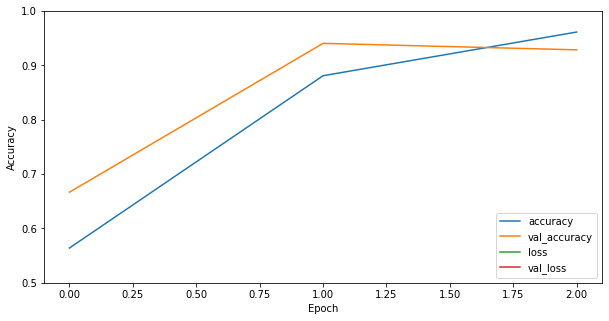

3/3 [==============================] - 0s 3ms/step
run_id: b45cd8a6063041a19acca9e4b2dd9ea5
artifacts_uri: file:///C:/Users/crist/Documents/tesis/SeizurePrediction/src/notebooks/mlruns/295688485592999226/b45cd8a6063041a19acca9e4b2dd9ea5/artifacts


<Figure size 432x288 with 0 Axes>

In [46]:
history = run_experiment_cnn(   input_shape_dataset,
                                X_train, 
                                y_train,
                                X_val,
                                y_val, 
                                X_test, 
                                y_test,
                                experiment_name = 'CNN test',
                                # num_classes=5,
                                input_shape_dataset = (X_train.shape[1], X_train.shape[2]),
                                epochs=3, 
                                # batch_size=8, 
                                debug=True,
                                filters=32,
                                )



In [42]:
import gc

gc.collect()

47382

In [ ]:
test_filter = [32, 64, 128, 256, 512]

for i in test_filter:
    
        history = run_experiment_cnn(   input_shape_dataset,
                                        X_train, 
                                        y_train,
                                        X_val,
                                        y_val, 
                                        X_test, 
                                        y_test,
                                        experiment_name = 'CNN test',
                                        # num_classes=5,
                                        input_shape_dataset = (X_train.shape[1], X_train.shape[2]),
                                        epochs=3, 
                                        # batch_size=8, 
                                        debug=True,
                                        filters=i,
                                        )


## MLP

In [29]:
# convert y to one-hot
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_val = keras.utils.to_categorical(y_val, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)


In [38]:
def run_experiment_mlp(
    input_shape: tuple,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    experiment_name: str = "Default MLP",
    epochs: int = 10,
    # batch_size=32, # better results without batch size
    debug: bool = False,
    
):


    X_train = X_train.astype("float32")
    X_test = X_test.astype("float32")

    with mlflow.start_run(nested=True) as run:

        # set name experiment
        mlflow.set_experiment(experiment_name)

        def create_model_mlp(
            input_shape_dataset: tuple = input_shape, num_classes: int = num_classes
        ) -> tf.keras.Model:

            """This function creates a basic convolutional neural network model with 2 convolutional layers, 2 dense layers and a softmax layer

            :param input_shape_dataset: shape of the input data
            :type input_shape_dataset: tuple
            :param num_classes: number of classes
            :type num_classes: int
            :return: return a model
            :rtype: tf.keras.Model
            """

            if debug:
                print("------------model summary---------------")
                print("input_shape_dataset", input_shape_dataset)
                print("num_classes", num_classes)

            input_shape_dataset: tuple
            
            model = Sequential()

            model.add(Flatten(input_shape=input_shape_dataset))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(32, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))

            return model

        model = create_model_mlp()

        # mlflow.tf

        # save summary of the model
        # with open("model_summary.txt", "w") as fh:
        #     model.summary(print_fn=lambda line: fh.write(line + "\n"))

        # create the compile
        model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

        # fit model
        history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            #  batch_size=batch_size,
            validation_data=(X_val, y_val),
            verbose=0,
        )

        # metrics mlflow
        # mlflow.log_metric("train_loss", history.history["loss"][-1])
        # mlflow.log_metric("train_accuracy", history.history["accuracy"][-1])
        # mlflow.log_metric("val_loss", history.history["val_loss"][-1])
        # mlflow.log_metric("val_accuracy", history.history["val_accuracy"][-1])

        # evaluate model
        acc_train = model.evaluate(X_train, y_train, verbose=0)[1]
        loss_train = model.evaluate(X_train, y_train, verbose=0)[0]
        mlflow.log_metric("loss", loss_train)
        mlflow.log_metric("accuracy", acc_train)

        acc = model.evaluate(X_test, y_test, verbose=0)[1]
        loss = model.evaluate(X_test, y_test, verbose=0)[0]
        mlflow.log_metric("test_loss", loss)
        mlflow.log_metric("test_accuracy", acc)

        # mlflow.tensorflow.log_model(model, "model")
        def plot_history(history):
            plt.figure(figsize=(10, 5))
            plt.plot(history.history['accuracy'], label='accuracy')
            plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
            plt.plot(history.history['loss'], label='loss')
            plt.plot(history.history['val_loss'], label = 'val_loss')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.ylim([0.5, 1])
            plt.legend(loc='lower right')
            plt.show()

        plot_history(history)

        plt.savefig(
            "Accuracy.png", dpi=300
        )  # no se exactamento donde lo guarda por lo que no puedo guardar en articafts
        mlflow.log_artifact("Accuracy.png")  # Esta linea no entrega falso

        # make matrix confusion
        y_pred = model.predict(X_test)
        # print(y_pred)
        y_pred = np.argmax(y_pred, axis=1)
        y_test = np.argmax(y_test, axis=1)
        cm = confusion_matrix(y_test, y_pred)
        # print(cm)



        mlflow.log_param("epochs", epochs)



        if debug:
            print("run_id: {}".format(run.info.run_id))
            print("artifacts_uri: {}".format(run.info.artifact_uri))
    return history

------------model summary---------------
input_shape_dataset (1280, 22)
num_classes 2


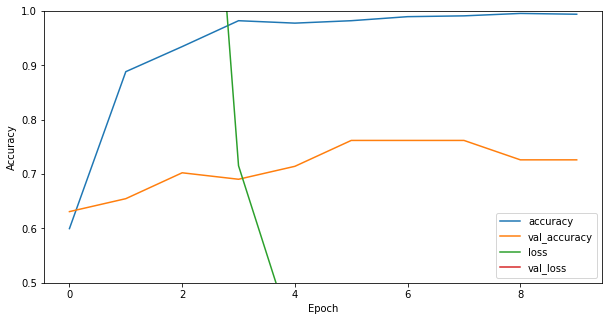

3/3 [==============================] - 0s 3ms/step
run_id: ada2bcf807c24b068843f780daeac362
artifacts_uri: file:///C:/Users/crist/Documents/tesis/SeizurePrediction/src/notebooks/mlruns/892140226408879587/ada2bcf807c24b068843f780daeac362/artifacts


<Figure size 432x288 with 0 Axes>

In [40]:

history = run_experiment_mlp(                       input_shape_dataset,
                                                    X_train,    
                                                    y_train,
                                                    X_val,
                                                    y_val,
                                                    X_test,
                                                    y_test,
                                                    experiment_name = 'MLP test',
                                                    epochs=10,
                                                    # batch_size=8,
                                                    debug=True,
                                                    )